<a href="https://colab.research.google.com/github/dk-wei/ml-algo-implementation/blob/main/Handle_Skewed_Outliers_%2B_Capping_%2B_Scaling_%2B_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考资料：[How to Handle Outliers](https://www.linkedin.com/pulse/how-handle-outliers-piyush-kumar/)


我们常常遇到的情况就是数据里面，大的特别大，小的特别小，放在一块儿作图就会特别的skewed. 我们可以找出例如80%percentile的值，或者1.5*(IOR, 75 percentile - 25 percentile)的值，然后进行capping，也就是替换大于的值为capping值。

步骤： 
1. 寻找threshold
  1. Percentile Capping
  2. IQR capping
2. MinMax Scaling * 100 
3. 分箱
5. 计数

In [361]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [362]:
df = pd.DataFrame({
               'A':[100,300,500,600,700,900,1300, 2000, 5000, 100000],
               'B':[1,2,3,4,5,6,7, 10, 9, 12],
             })

df

,A,B
0,100,1
1,300,2
2,500,3
3,600,4
4,700,5
5,900,6
6,1300,7
7,2000,10
8,5000,9
9,100000,12


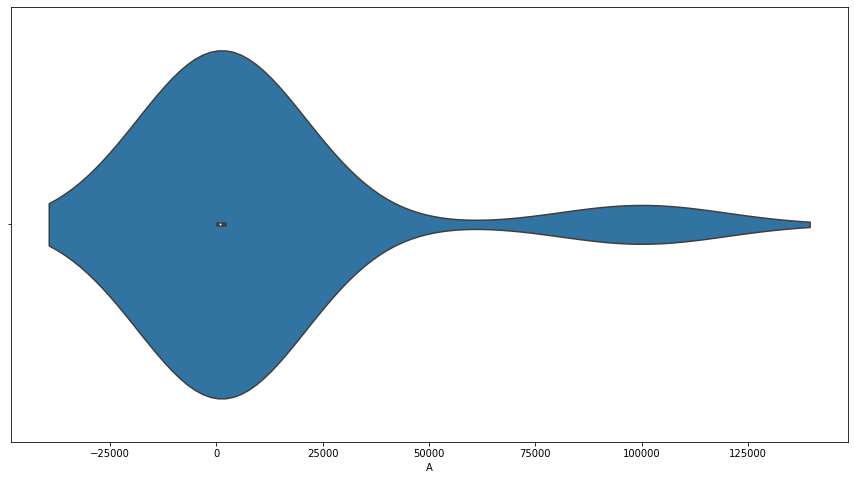

In [363]:
plt.figure(figsize=(15,8))

sns.violinplot(x=df['A'])

可以看到col A的最大值为100000，远远大于其他的值，下一步可以定义threshold。

In [364]:
# 方法1： 简单粗暴
threshold = df.A.quantile(0.80)

threshold

2600.0000000000005

In [365]:
# 方法2：根据2*IQR 
threshold = df.A.quantile(.75) + 1 * (df.A.quantile(.75) - df.A.quantile(.25))

threshold 


3125.0

下面进行capping，也就是所有大于threshold的数会被threshold给replace, 然后进行minmax scaling

In [366]:
df['A_clip'] = df['A'].clip(upper = threshold)

In [367]:
# Using sklearn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
arr_scaled = scaler.fit_transform(df[['A_clip']])

In [368]:
df[['A_clip_scaled']] = arr_scaled

In [369]:
df['A_scaled_clip_100'] = pd.DataFrame(scaler.fit_transform(df[['A_clip_scaled']])*100)

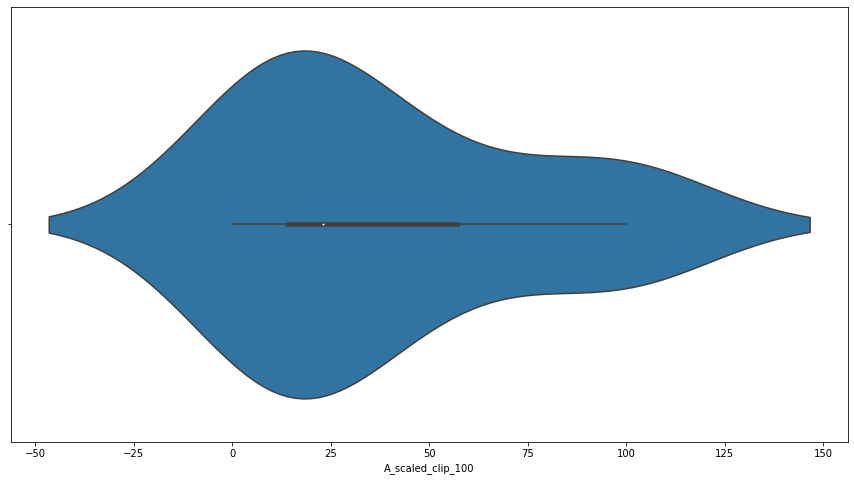

In [370]:
plt.figure(figsize=(15,8))

sns.violinplot(x=df['A_scaled_clip_100'])

In [371]:
df.A_scaled_clip_100.describe()

count     10.000000
mean      38.512397
std       36.925289
min        0.000000
25%       14.049587
50%       23.140496
75%       57.024793
max      100.000000
Name: A_scaled_clip_100, dtype: float64

In [372]:
df

,A,B,A_clip,A_clip_scaled,A_scaled_clip_100
0,100,1,100,0.000000,0.000000
1,300,2,300,0.066116,6.611570
2,500,3,500,0.132231,13.223140
3,600,4,600,0.165289,16.528926
4,700,5,700,0.198347,19.834711
5,900,6,900,0.264463,26.446281
6,1300,7,1300,0.396694,39.669421
7,2000,10,2000,0.628099,62.809917
8,5000,9,3125,1.000000,100.000000
9,100000,12,3125,1.000000,100.000000


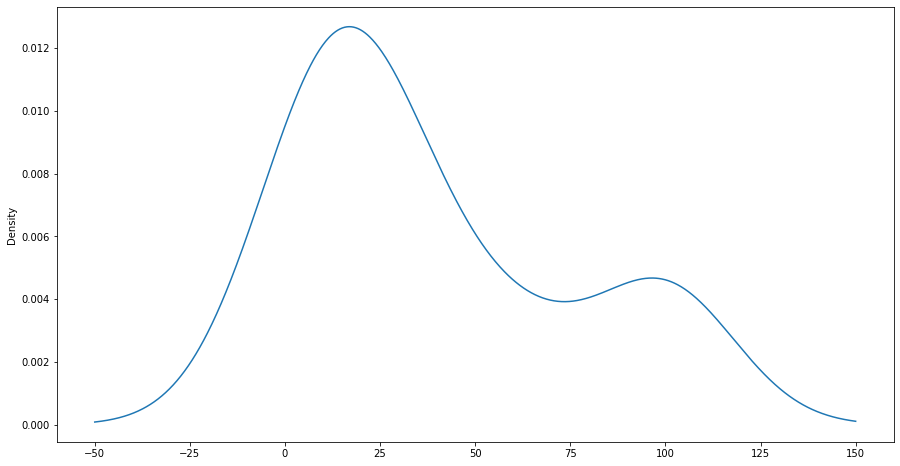

In [373]:
plt.figure(figsize=(15,8))

df.A_scaled_clip_100.plot.kde(bw_method=0.5)

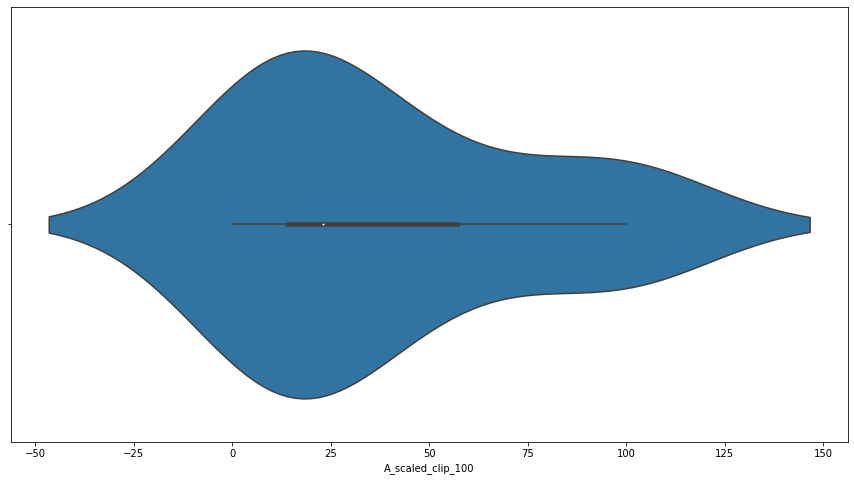

In [374]:
plt.figure(figsize=(15,8))

sns.violinplot(x=df['A_scaled_clip_100'])

下一步开始binnization，也就是分箱。注意我们这里的`below 20`和`above 80` 很有讲究

In [375]:
labels = ['below 20', '20-40', '40-60', '60-80','above 80']
bins = [float('-inf'), 20, 40, 60, 80, float('inf')]

In [376]:
df['A_scaled_clip_100_bin'] = pd.cut(df.A_scaled_clip_100, bins=bins, labels=labels)

In [377]:
df

,A,B,A_clip,A_clip_scaled,A_scaled_clip_100,A_scaled_clip_100_bin
0,100,1,100,0.000000,0.000000,below 20
1,300,2,300,0.066116,6.611570,below 20
2,500,3,500,0.132231,13.223140,below 20
3,600,4,600,0.165289,16.528926,below 20
4,700,5,700,0.198347,19.834711,below 20
5,900,6,900,0.264463,26.446281,20-40
6,1300,7,1300,0.396694,39.669421,20-40
7,2000,10,2000,0.628099,62.809917,60-80
8,5000,9,3125,1.000000,100.000000,above 80
9,100000,12,3125,1.000000,100.000000,above 80


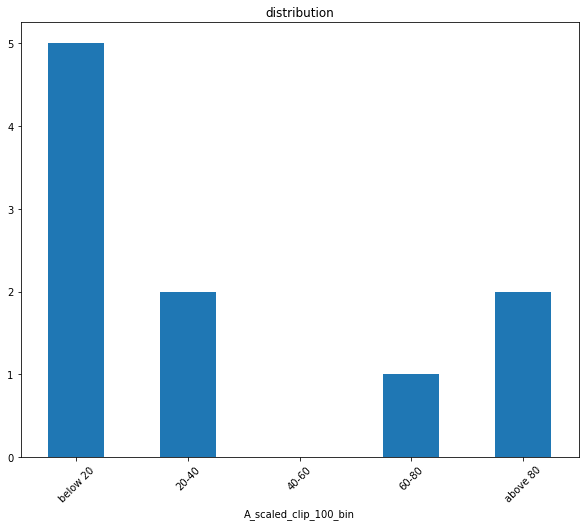

In [378]:
df.groupby('A_scaled_clip_100_bin')['A_scaled_clip_100'].count().plot(kind='bar',
                                                                            figsize=(10,8),
                                                                            title = 'distribution',
                                                                            rot = 45)